#MNIST Dataset

In [37]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from pathlib import Path
Path("scripts").mkdir(parents=True, exist_ok=True)

In [38]:
try:
  import torchinfo
except:
  !pip install torchinfo

### Getting the data

In [39]:
%%writefile scripts/data_setup.py

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from os import mkdir
#make directory
from pathlib import Path

def get_datasets(data_dir="data"):
  DATA_DIR = Path(data_dir)
  if DATA_DIR.is_dir():
    print(f"'{DATA_DIR}' directory already exists")
  else:
    print(f"'{DATA_DIR}' directory created...")
    DATA_DIR.mkdir(parents=True, exist_ok=True)

  train_transform = transforms.Compose([
      # transforms.TrivialAugmentWide(num_magnitude_bins=31),
      transforms.ToTensor()
  ])
  test_transform = transforms.Compose([
      # transforms.TrivialAugmentWide(num_magnitude_bins=31),
      transforms.ToTensor()
  ])

  train_data_set = datasets.MNIST(
      root=DATA_DIR,
      train=True,
      download=True,
      transform=train_transform,
      target_transform=None
  )
  test_data_set = datasets.MNIST(
      root=DATA_DIR,
      train=False,
      download=True,
      transform=test_transform,
      target_transform=None
  )
  class_names = train_data_set.classes
  return train_data_set, test_data_set, class_names # Return class_names as well

def get_daloaders(train_data, test_data, batch_size = 32):
  train_data_loader = DataLoader(dataset=train_data,
                                  batch_size=batch_size,
                                  shuffle=True)
  test_data_loader = DataLoader(dataset=test_data,
                                  batch_size=batch_size,
                                  shuffle=False)
  return train_data_loader, test_data_loader

Overwriting scripts/data_setup.py


In [40]:
from scripts import data_setup
train_data_set, test_data_set, class_names = data_setup.get_datasets(data_dir="data")
class_names

'data' directory already exists


['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

###Visualizing some images

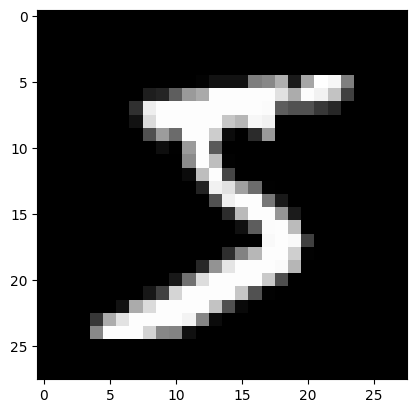

In [41]:
import matplotlib.pyplot as plt
img, label = train_data_set[0]
plt.imshow(img.permute(1, 2, 0), cmap="gray")

In [42]:
%%writefile scripts/utils.py

import torch
from torchinfo import summary
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random

#visualize some of the data
def plot_sample_images(train_data_set, k):
  """
  plot several random images k from the train_data_set
  """
  fig = plt.figure(figsize=(8, 5))
  nrows = int(k / 3)
  ncols = 3

  sample_images_indexes = random.sample(range(len(train_data_set)), k)

  for index_plot, index_img in enumerate(sample_images_indexes):
    # print(index_plot, index_img)
    fig.add_subplot(nrows, ncols, index_plot+1)
    img, label = train_data_set[index_img]
    plt.imshow(img.permute(1,2, 0), cmap="gray")
    plt.axis(False)
    title=f"Label: {label}"
    plt.title(title)

#device agnostic
def get_device():
  """
  get the available device, cpu or gpu
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  return device

def visualize_model(model):
  """
  visualize layers of our model
  """
  return summary(model, input_size=[1, 1, 28, 28])

def accuracy_fn(y_pred: torch.Tensor, y_true:torch.Tensor):
  """
  Evalautes accuracy of the model
  Return accuracy metric as a percentage
  """
  correct = torch.eq(y_pred, y_true).sum().item()
  acc = correct / len(y_pred) * 100
  return acc

def plot_model_results(model_results):
  """
  plot the model results
  """
  fig = plt.figure(figsize=(8, 3)) # Corrected figsize to be a tuple
  fig.add_subplot(1, 2, 1)
  plt.suptitle("Training vs. Test")
  plt.plot(model_results["train_loss"], label="Train")
  plt.plot(model_results["test_loss"], label="Test")
  plt.legend()
  # plt.axis(False) # Removed this line to show axes
  plt.title("Train Loss vs. Test Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  fig.add_subplot(1, 2, 2)
  plt.plot(model_results["train_acc"], label="Train")
  plt.plot(model_results["test_acc"], label="Test")
  plt.legend()
  # plt.axis(False) # Removed this line to show axes
  plt.title("Train Acc vs. Test Acc")
  plt.xlabel("Epoch")
  plt.ylabel("Acc")
  plt.show() # Added plt.show() to display the figure

Overwriting scripts/utils.py


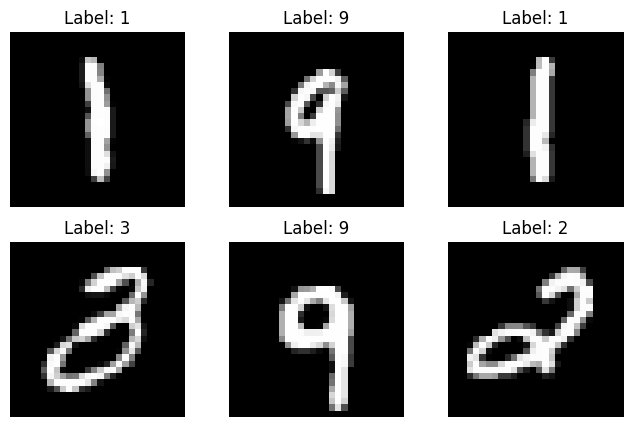

In [43]:
from scripts import utils
utils.plot_sample_images(train_data_set=train_data_set, k=6)

### Building the model

In [44]:
%%writefile scripts/engine.py
import torch
from torch import nn
class LinearModel(nn.Module):
  def __init__(self, hidden_units, output_features):
    super().__init__()
    self.layers = nn.Sequential(
        #flatten the image -> 28 x 28
        nn.Flatten(),
        nn.Linear(28 * 28, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_features)
    )
  def forward(self, x):
    return self.layers(x)

class CNNModelTinyVGG(nn.Module):
  def __init__(self, input_features,
               hidden_units,
               output_features):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(1, hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.MaxPool2d(kernel_size=3),

        nn.Conv2d(hidden_units, hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, output_features,
                  kernel_size=3,
                  stride=1,
                  padding=1)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.MaxPool2d(kernel_size=3),

        nn.Conv2d(hidden_units, hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, output_features,
                  kernel_size=3,
                  stride=1,
                  padding=1)
    )
    self.classification_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units * 3 * 3, output_features)
    )

  def forward(self, x):
    #operator fusion
    return(self.classification_layer(self.conv_block2(self.conv_block1(x))))

class ImprovedCNN(nn.Module):
  def __init__(self, input_features,
               hidden_units,
               output_features):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(1, hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),

        nn.Conv2d(hidden_units, hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),

        nn.Conv2d(hidden_units, hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),

        nn.Conv2d(hidden_units, hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )
    self.classification_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units * 7 * 7, output_features)
    )

  def forward(self, x):
    #operator fusion
    return(self.classification_layer(self.conv_block2(self.conv_block1(x))))




Overwriting scripts/engine.py


In [45]:
#initializing our model
from scripts import engine
from scripts import data_setup
from scripts import utils
_, _, class_names = data_setup.get_datasets()
device = utils.get_device()
model_01_linear = engine.LinearModel(hidden_units=100, output_features=len(class_names)).to(device)
model_01_linear

'data' directory already exists


LinearModel(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

### Visualize the layer of our model using `torch.info`


In [46]:
from scripts import utils
try:
  from torchinfo import summary
except:
  !pip install torchinfo
model_summary = utils.visualize_model(model_01_linear)
model01_linear_parameters = model_summary.total_params
model_summary

Layer (type:depth-idx)                   Output Shape              Param #
LinearModel                              [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 100]                  78,500
│    └─ReLU: 2-3                         [1, 100]                  --
│    └─Linear: 2-4                       [1, 100]                  10,100
│    └─ReLU: 2-5                         [1, 100]                  --
│    └─Linear: 2-6                       [1, 10]                   1,010
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.36
Estimated Total Size (MB): 0.36

### Turn our datasets into dataloaders

In [47]:
train_data_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

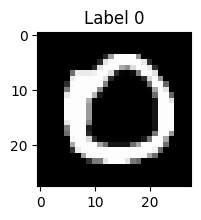

In [48]:
from scripts import data_setup
train_data_loader, test_data_loader = data_setup.get_daloaders(train_data=train_data_set,
                                             test_data=test_data_set)
train_data_loader, test_data_loader
images, labels = next(iter(train_data_loader))
images[0].shape
plt.figure(figsize=(4, 2))
plt.imshow(images[0].permute(1, 2,0), cmap="grey")
title =f"Label {labels[0]}"
plt.title(title)
plt.show()


### Train our model

In [49]:
%%writefile scripts/train.py
import torch
from tqdm.auto import tqdm
def train_step(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer:torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device:torch.device):
  #turn our model into training mode
  model.train()

  #track train_loss, train_acc
  train_loss, train_acc = 0, 0

  #batch loop
  batches_no = len(data_loader)
  for batch, (X, y) in enumerate(data_loader):
    #ensure X and y are on the same device
    X, y = X.to(device), y.to(device)

    #forward pass
    y_pred = model(X)

    #evaluate loss
    loss = loss_fn(y_pred, y)
    #accumulate loss
    train_loss += loss.item()

    #evaluate and accuracy
    train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

    #zero gradient
    optimizer.zero_grad()

    #backward propagation
    loss.backward()

    #optimize parameters
    optimizer.step()

  #average train_loss, and train_acc for all the bacthes
  train_loss /= batches_no
  train_acc /= batches_no

  return train_loss, train_acc

def test_step(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device:torch.device):
  #turn our model into evaluation mode
  model.eval()

  #track train_loss, train_acc
  test_loss, test_acc = 0, 0

  #use torch.inference mode
  with torch.inference_mode():
    #batch loop
    batches_no = len(data_loader)
    for batch, (X, y) in enumerate(data_loader):
      #ensure X and y are on the same device
      X, y = X.to(device), y.to(device)

      #forward pass
      y_pred = model(X)

      #evaluate loss
      loss = loss_fn(y_pred, y)
      #accumulate loss
      test_loss += loss.item()

      #evaluate and accuracy
      test_acc += accuracy_fn(y_pred.argmax(dim=1), y)

    #average train_loss, and train_acc for all the bacthes
    test_loss /= batches_no
    test_acc /= batches_no

    return test_loss, test_acc


def train_model(model:torch.nn.Module,
                train_data_loader:torch.utils.data.DataLoader,
                test_data_loader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                accuracy_fn,
                device:torch.device,
                epochs=100
                ):
  model_results = {"train_loss":[],
                    "train_acc":[],
                    "test_loss":[],
                    "test_acc":[]
                    }
  for epoch in tqdm(range(epochs)):
    #perform train_step
    train_loss, train_acc = train_step(model=model,
                data_loader=train_data_loader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                device=device
                )
    #append train_loss, and train_acc
    model_results["train_loss"].append(train_loss)
    model_results["train_acc"].append(train_acc)

    #perform test_step
    test_loss, test_acc = test_step(model=model,
                data_loader=test_data_loader,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                device=device
                )
    #append train_loss, and train_acc
    model_results["test_loss"].append(test_loss)
    model_results["test_acc"].append(test_acc)

    #print results
    print(f"Epoch: {epoch} | Train Loss : {train_loss:.4f} Train accuracy : {train_acc:.2f}% | Test Loss : {test_loss:.4f} Test accuracy : {test_acc:.2f}% ")

  return model_results


Overwriting scripts/train.py


In [50]:
#set loss function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_01_linear.parameters(),
                            lr=0.01)

In [51]:
model ={"key1":10, "key2":30}
model["new key"]=20
model

{'key1': 10, 'key2': 30, 'new key': 20}

In [52]:
next(model_01_linear.parameters()).device

device(type='cuda', index=0)

In [53]:
from timeit import default_timer as timer
from scripts import train, utils
device = utils.get_device()
start_train_time = timer()
model01_results = train.train_model(model=model_01_linear,
            train_data_loader=train_data_loader,
            test_data_loader=test_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=utils.accuracy_fn,
            epochs=10,
            device=device
            )
end_train_time = timer()
model01_training_time = end_train_time - start_train_time
print(f"Model training time:{model01_training_time} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss : 1.1486 Train accuracy : 71.26% | Test Loss : 0.4252 Test accuracy : 88.35% 
Epoch: 1 | Train Loss : 0.3784 Train accuracy : 89.26% | Test Loss : 0.3184 Test accuracy : 90.89% 
Epoch: 2 | Train Loss : 0.3046 Train accuracy : 91.24% | Test Loss : 0.2679 Test accuracy : 92.35% 
Epoch: 3 | Train Loss : 0.2636 Train accuracy : 92.36% | Test Loss : 0.2389 Test accuracy : 92.95% 
Epoch: 4 | Train Loss : 0.2336 Train accuracy : 93.22% | Test Loss : 0.2120 Test accuracy : 93.74% 
Epoch: 5 | Train Loss : 0.2096 Train accuracy : 94.05% | Test Loss : 0.1951 Test accuracy : 94.46% 
Epoch: 6 | Train Loss : 0.1902 Train accuracy : 94.57% | Test Loss : 0.1835 Test accuracy : 94.56% 
Epoch: 7 | Train Loss : 0.1738 Train accuracy : 95.06% | Test Loss : 0.1714 Test accuracy : 94.95% 
Epoch: 8 | Train Loss : 0.1596 Train accuracy : 95.36% | Test Loss : 0.1584 Test accuracy : 95.40% 
Epoch: 9 | Train Loss : 0.1472 Train accuracy : 95.75% | Test Loss : 0.1456 Test accuracy : 95.68% 


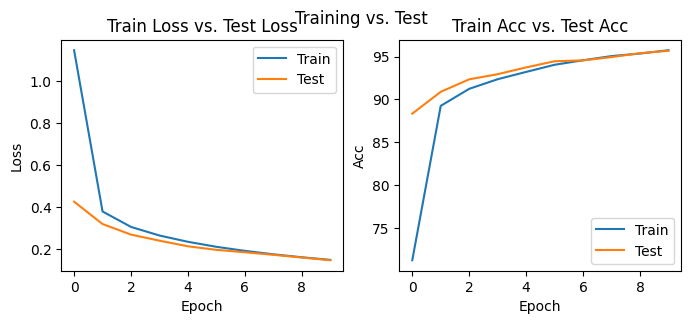

In [54]:
#plot the results
from scripts import utils
utils.plot_model_results(model_results=model01_results)

### Evaluate the Model

In [55]:
%%writefile scripts/test.py

from tqdm.auto import tqdm
import torch

def eval_model(model: torch.nn.Module,
               test_data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device:torch.device):
  """
  Returns a dictionary containing the results model predicting on data loader
  """
  loss, acc = 0, 0
  batches_no = len(test_data_loader)
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(test_data_loader):
      #make predictions
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      #accumulate loss and accuracy per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y, y_pred.argmax(dim=1))

    #average loss and accuracy
    loss /= batches_no
    acc /= batches_no

  return {"model_name": model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

Overwriting scripts/test.py


In [56]:
from scripts import test, utils
accuracy_fn = utils.accuracy_fn
model01_eval_results = test.eval_model(model=model_01_linear,
           test_data_loader=test_data_loader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn,
           device=device)
model01_eval_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'LinearModel',
 'model_loss': 0.14555685222148895,
 'model_acc': 95.67691693290735}

### Trying out feature extraction using CNN

In [57]:
class_names
from scripts import engine
model02_cnn = engine.CNNModelTinyVGG(input_features=1,
                       hidden_units=10,
                       output_features=len(class_names))

###Visualize our model layers

In [58]:
from scripts import utils
model_summary = utils.visualize_model(model=model02_cnn)
model01_cnn_parameters = model_summary.total_params
model_summary

Layer (type:depth-idx)                   Output Shape              Param #
CNNModelTinyVGG                          [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 9, 9]             --
│    └─Conv2d: 2-1                       [1, 10, 28, 28]           100
│    └─MaxPool2d: 2-2                    [1, 10, 9, 9]             --
│    └─Conv2d: 2-3                       [1, 10, 9, 9]             910
│    └─ReLU: 2-4                         [1, 10, 9, 9]             --
│    └─Conv2d: 2-5                       [1, 10, 9, 9]             910
├─Sequential: 1-2                        [1, 10, 3, 3]             --
│    └─Conv2d: 2-6                       [1, 10, 9, 9]             910
│    └─MaxPool2d: 2-7                    [1, 10, 3, 3]             --
│    └─Conv2d: 2-8                       [1, 10, 3, 3]             910
│    └─ReLU: 2-9                         [1, 10, 3, 3]             --
│    └─Conv2d: 2-10                      [1, 10, 3, 3]             910
├─Sequent

In [59]:
from scripts import train, utils
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model02_cnn.parameters(),
                                  lr=0.01)
device = utils.get_device()
accuracy_fn = utils.accuracy_fn
start_training_time = timer()
model02_cnn_results = train.train_model(model=model02_cnn,
                                        train_data_loader=train_data_loader,
                                        test_data_loader=test_data_loader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        accuracy_fn=accuracy_fn,
                                        device=device,
                                        epochs=10
                                        )
end_training_time = timer()
model02_training_time = end_training_time - start_training_time
print(f"Model training time:{model01_training_time} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss : 2.3018 Train accuracy : 11.10% | Test Loss : 2.3009 Test accuracy : 11.35% 
Epoch: 1 | Train Loss : 2.3007 Train accuracy : 11.24% | Test Loss : 2.2999 Test accuracy : 11.35% 
Epoch: 2 | Train Loss : 2.2980 Train accuracy : 11.24% | Test Loss : 2.2918 Test accuracy : 11.40% 
Epoch: 3 | Train Loss : 1.2392 Train accuracy : 58.77% | Test Loss : 0.2868 Test accuracy : 90.67% 
Epoch: 4 | Train Loss : 0.2526 Train accuracy : 92.17% | Test Loss : 0.1817 Test accuracy : 94.29% 
Epoch: 5 | Train Loss : 0.1874 Train accuracy : 94.16% | Test Loss : 0.1452 Test accuracy : 95.30% 
Epoch: 6 | Train Loss : 0.1588 Train accuracy : 95.06% | Test Loss : 0.1402 Test accuracy : 95.41% 
Epoch: 7 | Train Loss : 0.1396 Train accuracy : 95.66% | Test Loss : 0.1275 Test accuracy : 95.97% 
Epoch: 8 | Train Loss : 0.1258 Train accuracy : 96.12% | Test Loss : 0.1058 Test accuracy : 96.55% 
Epoch: 9 | Train Loss : 0.1124 Train accuracy : 96.52% | Test Loss : 0.0996 Test accuracy : 96.78% 


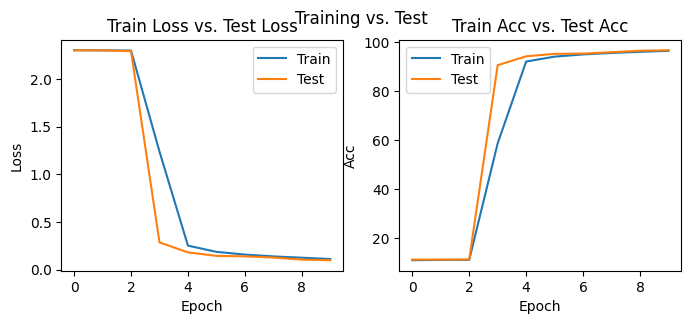

In [60]:
#plot the loss and accuracy
from scripts import utils
utils.plot_model_results(model02_cnn_results)

In [61]:
from scripts import test, utils
accuracy_fn = utils.accuracy_fn
model02_eval_results = test.eval_model(model=model02_cnn,
           test_data_loader=test_data_loader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn,
           device=device)
model02_eval_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'CNNModelTinyVGG',
 'model_loss': 0.09956586360931396,
 'model_acc': 96.77515974440895}

### Intializing out improved CNN model

In [62]:
from scripts import engine, utils
model03_improved_cnn = engine.ImprovedCNN(input_features=1,
                                        hidden_units=10,
                                        output_features=len(class_names))

### Visualize our improved CNN model

In [63]:
from scripts import utils
model_summary = utils.visualize_model(model=model03_improved_cnn)
model03_cnn_parameters = model_summary.total_params
model_summary

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedCNN                              [1, 10]                   1,820
├─Sequential: 1-1                        [1, 10, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 10, 28, 28]           100
│    └─ReLU: 2-2                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 10, 28, 28]           910
│    └─ReLU: 2-4                         [1, 10, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 10, 14, 14]           --
├─Sequential: 1-2                        [1, 10, 7, 7]             --
│    └─Conv2d: 2-6                       [1, 10, 14, 14]           910
│    └─ReLU: 2-7                         [1, 10, 14, 14]           --
│    └─Conv2d: 2-8                       [1, 10, 14, 14]           910
│    └─ReLU: 2-9                         [1, 10, 14, 14]           --
│    └─MaxPool2d: 2-10                   [1, 10, 7, 7]             --
├─Sequen

### Training the Model

In [64]:
from scripts import train, utils
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model03_improved_cnn.parameters(),
                                  lr=0.01)
device = utils.get_device()
accuracy_fn = utils.accuracy_fn
start_training_time = timer()
model03_cnn_results = train.train_model(model=model03_improved_cnn,
                                        train_data_loader=train_data_loader,
                                        test_data_loader=test_data_loader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        accuracy_fn=accuracy_fn,
                                        device=device,
                                        epochs=10
                                        )
end_training_time = timer()
model03_training_time = end_training_time - start_training_time
print(f"Model training time:{model01_training_time} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss : 1.9084 Train accuracy : 29.47% | Test Loss : 0.3495 Test accuracy : 89.59% 
Epoch: 1 | Train Loss : 0.2007 Train accuracy : 93.80% | Test Loss : 0.1179 Test accuracy : 96.23% 
Epoch: 2 | Train Loss : 0.1022 Train accuracy : 96.82% | Test Loss : 0.0987 Test accuracy : 96.91% 
Epoch: 3 | Train Loss : 0.0836 Train accuracy : 97.46% | Test Loss : 0.0783 Test accuracy : 97.40% 
Epoch: 4 | Train Loss : 0.0731 Train accuracy : 97.77% | Test Loss : 0.0538 Test accuracy : 98.29% 
Epoch: 5 | Train Loss : 0.0666 Train accuracy : 97.92% | Test Loss : 0.0572 Test accuracy : 98.08% 
Epoch: 6 | Train Loss : 0.0617 Train accuracy : 98.06% | Test Loss : 0.0490 Test accuracy : 98.23% 
Epoch: 7 | Train Loss : 0.0582 Train accuracy : 98.18% | Test Loss : 0.0499 Test accuracy : 98.41% 
Epoch: 8 | Train Loss : 0.0548 Train accuracy : 98.25% | Test Loss : 0.0609 Test accuracy : 98.03% 
Epoch: 9 | Train Loss : 0.0521 Train accuracy : 98.39% | Test Loss : 0.0468 Test accuracy : 98.46% 


### Loss and Accuracy of our Model

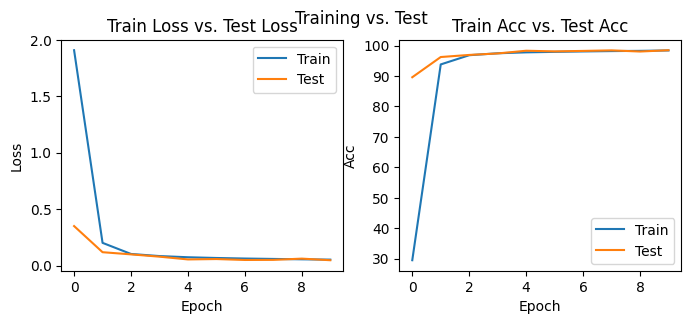

In [65]:
from scripts import utils
utils.plot_model_results(model03_cnn_results)

### Evaluate the model accuracy

In [66]:
from scripts import test
from scripts import utils
accuracy_fn = utils.accuracy_fn
device = utils.get_device()
model03_cnn_results = test.eval_model(model=model03_improved_cnn,
                                      test_data_loader=test_data_loader,
                                      loss_fn=loss_fn,
                                      accuracy_fn=accuracy_fn,
                                      device=device
                                      )
model03_cnn_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ImprovedCNN',
 'model_loss': 0.04679400846362114,
 'model_acc': 98.46246006389777}

In [67]:
### Visualize our model performance results
import pandas as pd
import plotly.express as px
import seaborn as sns
model_performance_results = pd.DataFrame([model01_eval_results,
                                          model02_eval_results,
                                          model03_cnn_results])
model_performance_results
fig = px.bar(model_performance_results,
       x="model_name",
       y=["model_acc", "model_loss"],
       color="model_name")

fig.update_layout(
    xaxis_title="Model Name",
    yaxis_title="Model Accuracy (%)"
)
fig.update_traces(
    width=0.5
)
# sns.barplot(data=model_performance_results,
#             x="model_name",
#             y="model_acc"
#             )

In [68]:
model_performance_results["training_time"] = [model01_training_time, model02_training_time, model03_training_time]
model_performance_results["parameters"] = [model01_linear_parameters, model01_cnn_parameters, model03_cnn_parameters]
model_performance_results

,model_name,model_loss,model_acc,training_time,parameters
0,LinearModel,0.145557,95.676917,107.169887,89610
1,CNNModelTinyVGG,0.099566,96.775160,130.384603,5560
2,ImprovedCNN,0.046794,98.462460,124.190501,9560


In [69]:
!rm -rf data